In [1]:
#%%
from  datetime import datetime
import math
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import fft
from scipy import signal as sig



In [3]:
#%%
# Load data
# WE JUST INTERESTING ONLY DATATIME OF BOOKING BECAUSE WE FOLLOW TIME SERIES REGRESSION

names = ['timestamp']
df = pd.read_csv(os.getcwd() + f'\\data\\data.csv', names=['timestamp'], header=0,  usecols=[1])

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_trunc'] = df['timestamp'].dt.floor('h')
df['N'] = 1
df.head()


,timestamp,timestamp_trunc,N
0,2024-05-10 12:48:26,2024-05-10 12:00:00,1
1,2024-05-16 18:34:45,2024-05-16 18:00:00,1
2,2024-05-23 10:24:32,2024-05-23 10:00:00,1
3,2024-05-10 14:31:00,2024-05-10 14:00:00,1
4,2024-05-02 18:01:40,2024-05-02 18:00:00,1


In [7]:
#%%
# Count travels/bookings per hour
counts = df.groupby(['timestamp_trunc']).sum(numeric_only=True)
counts = counts[['N']]
counts_dict = counts['N'].to_dict()



In [10]:
# %%
# Create a new DF with time & signal, filling in missing hours with 0 calls
data = pd.DataFrame()
data['time'] = pd.date_range(min(counts.index), max(counts.index), freq = 'h')
data.set_index('time')
data['time_sec'] = (data.time - min(data.time)).dt.total_seconds()
data['signal'] = data.time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

# time_sec is the hourly timestamp converted to seconds
X = pd.DataFrame(data['time_sec']) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y) 
data['pred_signal_linreg'] = model.predict(X)
data['residuals'] = data['signal'] - data['pred_signal_linreg']

time = data['time']
residuals = data['residuals']


In [11]:
#%%
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))


Slope: -2.73e-06, Intercept: 70.85
R-squared: 2.13e-03


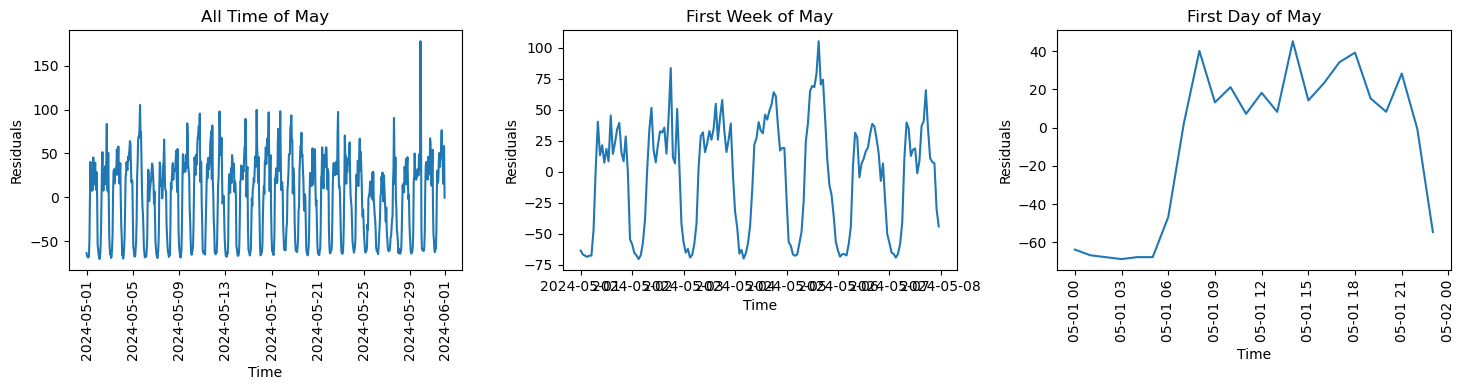

In [12]:
# %%
## Plot residuals in the time domain
plt.figure(figsize=(15, 4))

ax1 = plt.subplot( 1, 3, 1 )
ax1.plot(time, residuals, label='residuals')
ax1.set_title('All Time of May')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 3, 2 )
ax2.plot(time[:N], residuals[:N])
ax2.set_title('First Week of May')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

N = 24 
ax3 = plt.subplot( 1, 3, 3 )
ax3.plot(time[:N], residuals[:N])
ax3.set_title('First Day of May')
ax3.set_ylabel( 'Residuals' )
ax3.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35')])

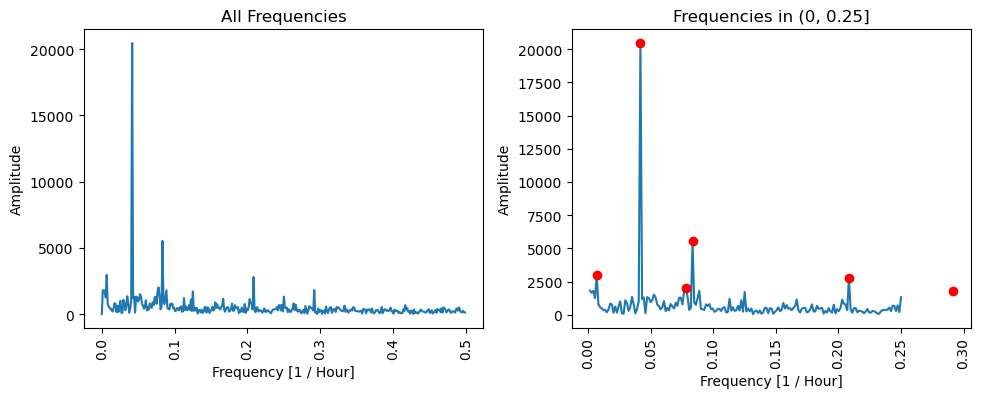

In [13]:
# %%
#PLOT TIME/FREQ

fft_output = fft.fft(residuals.values)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals.values))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=1600)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [14]:
# %%

output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq (1/hour),amplitude,period (days),fft
1,31,0.041667,20466.259172,1.000000,-14864.434090+14068.275079j
3,62,0.083333,5528.474882,0.500000,-1817.973185+ 5221.015995j
0,5,0.006720,2963.525904,6.200000,-2226.942469+ 1955.303819j
4,155,0.208333,2805.518810,0.200000,-2137.304418+ 1817.378776j
2,58,0.077957,2019.718516,0.534483,-221.680414+ 2007.516047j
5,217,0.291667,1813.299777,0.142857,278.433789- 1791.795387j


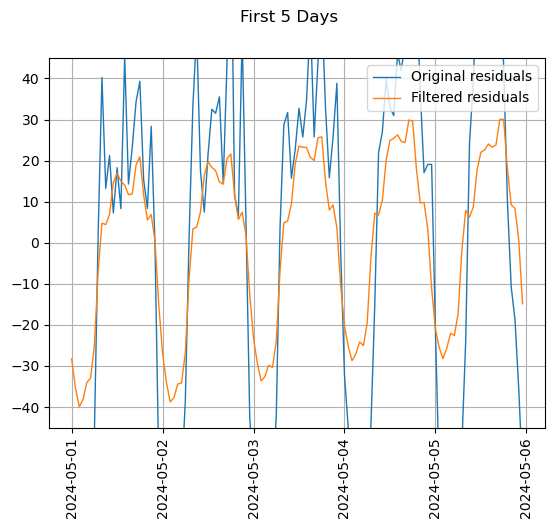

In [15]:
# %%
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 24 * 5
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.ylim((-45, 45))
plt.xticks(rotation=90)

print()

In [16]:
# %%

from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms


,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,-14864.434090+14068.275079j,0.041667,20466.259172,2.383705
FT_2,-1817.973185+ 5221.015995j,0.083333,5528.474882,1.905869
FT_3,-2226.942469+ 1955.303819j,0.006720,2963.525904,2.421054
FT_4,-2137.304418+ 1817.378776j,0.208333,2805.518810,2.436917
FT_5,-221.680414+ 2007.516047j,0.077957,2019.718516,1.680776
FT_6,278.433789- 1791.795387j,0.291667,1813.299777,-1.416636


In [17]:
# %%

for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 3600)
    p = fourier_terms_dict[key]['phase']
    data[key] = data['time_sec'].apply(lambda t: a * math.cos(w*t + p))

data['FT_All'] = 0
for column in list(fourier_terms.index):
    data['FT_All'] = data['FT_All'] + data[column]


# Sample 
data[['signal', 'time_sec', 'FT_All']  + list(fourier_terms.index)]


,signal,time_sec,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6
0,7,0.0,-20989.900787,-14864.434090,-1817.973185,-2226.942469,-2137.304418,-221.680414,278.433789
1,4,3600.0,-26281.526841,-17999.078303,-4184.918959,-2307.496988,-2308.628185,-1140.081878,1658.677472
2,3,7200.0,-29706.707911,-19907.115074,-5430.519078,-2383.937826,942.270534,-1790.378038,-1137.028428
3,2,10800.0,-28429.027667,-20458.514851,-5221.015995,-2456.128711,2796.383304,-2019.643167,-1070.108248
4,3,14400.0,-25329.948832,-19615.700651,-3612.545892,-2523.940942,505.243979,-1773.962543,1690.957218
...,...,...,...,...,...,...,...,...,...
739,109,2660400.0,11284.439559,9741.711593,4184.918959,-1767.732958,-1594.105297,1452.344420,-732.697159
740,79,2664000.0,6202.047775,4751.266561,5430.519078,-1866.564302,-2642.548398,1941.898264,-1412.523429
741,97,2667600.0,6360.862299,-562.969435,5221.015995,-1962.068036,226.221591,1974.789096,1463.873089
742,122,2671200.0,677.330465,-5838.839995,3612.545892,-2054.073903,2759.649310,1543.282202,654.766958


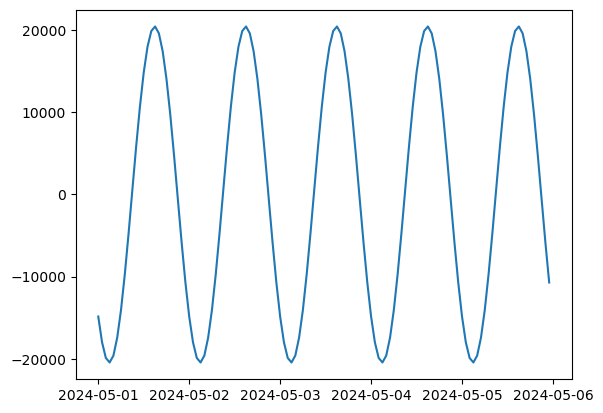

In [18]:
# %%
# Check the first Fourier term, which should have a period = 1 day
plt.plot(data['time'][:24*5], data['FT_1'][:24*5])


In [19]:
#%%
#THE ONLY THAT WE CAN ADD IS WEEK DATE BECAUSE NOW WE REFER TO 1 HOUR WINDOW TIME INTERVAL 

data["weekDate"] = pd.to_datetime(data['time']).dt.dayofweek


In [20]:
#%%
# Save modeling_data

data.to_csv('data/modeling_data.csv', index=False)


